In [1]:
import numpy as np
from numpy import ndarray

from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)

In [2]:
%load_ext autoreload
%autoreload 2

# Boston data

In [3]:
from sklearn.datasets import load_boston

In [4]:
boston = load_boston()

In [5]:
data = boston.data
target = boston.target
features = boston.feature_names

Summary of Boston data
---
* data: (506, 13)
* target: (506, )
* features: (13, ) `['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']`

# SciKit Learn Linear Regression

## Data prep
* Split the data into two folds: train and test sets where 354 and 152 examples repspectively. 
* For the sake of consistency, reshape 1d-array into 2d-array for target: for example, (152, ) to (152, 1)

In [6]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
data = s.fit_transform(data)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)

y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

## Regression
* preds: (152, ) or (152, 1)? (152, 1) (since y_train is 2d-array?)
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
* `lr` has two attrributes: `coef_` and `intercept_`
* 


In [8]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)
preds = lr.predict(X_test)

In [9]:
print(lr.coef_, lr.intercept_)

[[-1.0148  0.7065  0.276   0.7092 -2.206   2.3793  0.7133 -2.6625  2.6325
  -1.8172 -2.3266  0.8465 -4.1889]] [22.6195]


What's the meaning of the largest value in coeffifients? Most important feature?

In [10]:
max_coef_idx = np.argmax(lr.coef_[0])
features[max_coef_idx]

'RAD'

In [11]:
import matplotlib.pyplot as plt

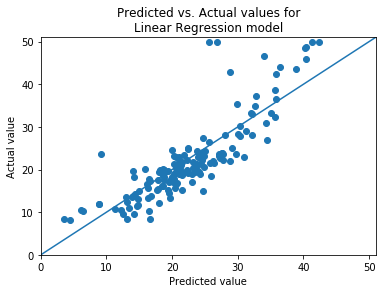

In [38]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\nLinear Regression model")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);
#plt.savefig("")

## Testing chaning feature

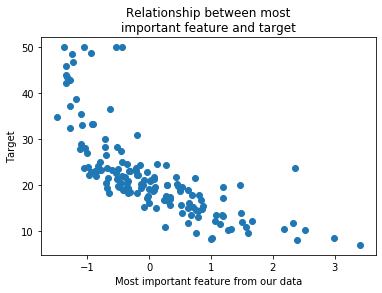

In [37]:
plt.scatter(X_test[:, 12], y_test)
plt.xlabel("Most important feature from our data")
plt.ylabel("Target")
plt.title("Relationship between most\nimportant feature and target");

Non-linear relationship

## Model Error

In [14]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

In [15]:
def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [16]:
round(mae(preds, y_test), 4)

3.5671

In [17]:
round(rmse(preds, y_test), 4)

5.0476

In [18]:
np.round(lr.coef_, 2)

array([[-1.01,  0.71,  0.28,  0.71, -2.21,  2.38,  0.71, -2.66,  2.63,
        -1.82, -2.33,  0.85, -4.19]])

# Linear Regression from Scratch

In [19]:
def forward_linear_regression(X_batch: ndarray, 
                              y_batch: ndarray, 
                              weights: Dict[str, ndarray]
                              )->Tuple[float, Dict[str, ndarray]]:
    '''
    Forward pass for the step-by-step linear regression.
    '''
    assert X_batch.shape[0] == y_batch.shape[0]
    
    assert X_batch.shape[1] == weights['W'].shape[0]
    
    assert weights['B'].shape == (1, 1)
    
    # compute the operations on the forward pass
    N = np.dot(X_batch, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y_batch - P, 2))
    
    # save the information coputed on the forward pass
    forward_info: Dict[str, ndarray] = {}
    #forward_info = dict()
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y_batch
    
    return loss, forward_info

In [20]:
def to_2d_np(a: ndarray, 
             type: str = "col")-> ndarray:
    '''
    Turns a 1D tensor into 2D
    '''
    assert a.ndim == 1, "Input tensors must be 1 dimensional"
    
    if type == "col":
        return a.reshape(-1, 1)
    elif type == "row":
        return a.reshape(1, -1)
    else:
        raise ValueError("type should be 'col' or ''row'.")

In [21]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permuttion, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [22]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute dLdW and dLdB for the step-by-step linear regression model.
    '''
    batch_size = forward_info['X'].shape[0]

    dLdP = -2 * (forward_info['y'] - forward_info['P'])

    dPdN = np.ones_like(forward_info['N'])

    dPdB = np.ones_like(weights['B'])

    dLdN = dLdP * dPdN

    dNdW = np.transpose(forward_info['X'], (1, 0))
    
    # need to use matrix multiplication here, with dNdW on the left    
    dLdW = np.dot(dNdW, dLdN)

    # need to sum along dimension representing the batch size
    dLdB = (dLdP * dPdB).sum(axis=0)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

In [23]:
Batch = Tuple[ndarray, ndarray]

In [24]:
def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, "X and y must be 2 dimensional"
    
    if start + batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start + batch_size], y[start:start + batch_size]
    
    return X_batch, y_batch

In [25]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]) -> Tuple[Dict[str, ndarray], float]:
    '''
    Generate predictions and calculate loss for a step-by-step linear regression
    (used mostly during inference)
    '''
    N = np.dot(X, weights['W'])
    
    P = N + weights['B']
    
    loss = np.mean(np.power(y - P, 2))
    
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['y'] = y
    
    return forward_info, loss

In [26]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B
    
    return weights

In [27]:
def train(X: ndarray,
          y: ndarray,
          n_iter: int = 1000,
          learning_rate: float = 0.01,
          batch_size: int = 100,
          return_losses: bool = False,
          return_weights: bool = False,
          seed: int = 1) -> None:
    '''
    Train model for a certain number of epochs.
    '''
    if seed:
        np.random.seed(seed)
    start = 0
    
    # Initialize weights
    weights = init_weights(X.shape[1])
    
    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []
        
    for i in range(n_iter):
        
        #Generate batch
        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0
        
        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size
        
        # Tain net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)
        
        if return_losses:
            losses.append(loss)
            
        loss_grads = loss_gradients(forward_info, weights)
        
        # Optimization with Gradient Descent
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]
    
    if return_weights:
        return losses, weights
    
    return None

In [28]:
train_info = train(X_train, y_train, 
                   n_iter = 1000,
                   learning_rate = 0.001,
                   batch_size = 23,
                   return_losses = True,
                   return_weights = True,
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

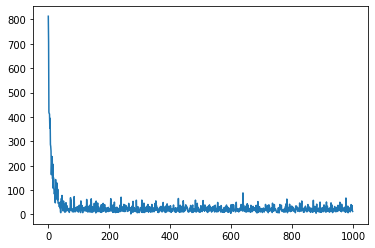

In [29]:
plt.plot(list(range(1000)), losses);

In [30]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]):
    '''
    Generate predictions from the step-by-step linear regression model.
    '''
    
    N = np.dot(X, weights['W'])
    
    return N + weights['B']

In [31]:
preds = predict(X_test, weights)

In [33]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 3.5644 
Root mean squared error: 5.0497


In [34]:
np.round(y_test.mean(), 4)

22.0776

In [35]:
np.round(rmse(preds, y_test) / y_test.mean(), 4)

0.2287

RMSE is 23% on average of y.

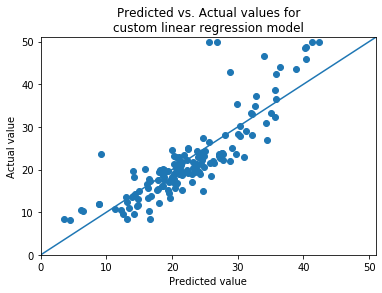

In [36]:
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model");
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);

In [39]:
NUM = 40
a = np.repeat(X_test[:, :-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)

test_feature = np.concatenate([a, b], axis=1)
test_preds = predict(test_feature, weights)[:, 0]

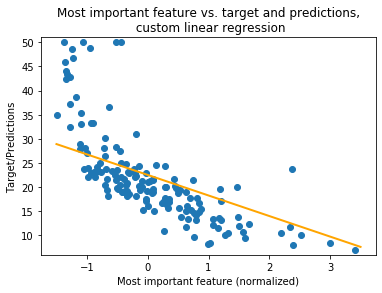

In [40]:
plt.scatter(X_test[:, 12], y_test)
plt.plot(np.array(test_feature[:, -1]), test_preds, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n custom linear regression");

## Coefficients

In [41]:
np.round(weights['W'].reshape(-1), 4)

array([-1.0954,  0.7353,  0.1977,  0.7475, -2.2849,  2.2006,  0.7195,
       -2.6384,  2.5358, -1.6892, -2.3162,  0.8435, -4.2553])

In [42]:
np.round(lr.coef_, 4)

array([[-1.0148,  0.7065,  0.276 ,  0.7092, -2.206 ,  2.3793,  0.7133,
        -2.6625,  2.6325, -1.8172, -2.3266,  0.8465, -4.1889]])

In [43]:
np.round(weights['B'], 4)

array([[22.6312]])

In [44]:
np.round(lr.intercept_, 4)

array([22.6195])

Coefficients are the same in the SciKit Learn linear regression as in the "custom" linear regression.